In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy as np

/albedo/home/pscholz/.conda/envs/py37/lib/python3.7/site-packages/xarray/core/options.py:93: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  FutureWarning,
/albedo/home/pscholz/.conda/envs/py37/lib/python3.7/site-packages/xarray/core/options.py:93: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  FutureWarning,


/albedo/home/pscholz/tripyview


In [2]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'vprofile_clim'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'salt'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
box_regions = list()
box_regions.append('ocean_basins/Arctic_Basin.shp')
box_regions.append('ocean_basins/Eurasian_Basin.shp')
box_regions.append('mpas_region/Canada_Basin.shp')
box_regions.append('mpas_region/North_Atlantic_Ocean.shp')
box_regions.append('mpas_region/Greenland_Sea.shp')
box_regions.append('mpas_region/Irminger_Sea.shp')
box_regions.append('mpas_region/Norwegian_Sea.shp')
box_regions.append('mpas_region/Labrador_Sea.shp')
# box_regions.append('mpas_region/North_Pacific_Ocean.shp')
# box_regions.append('mpas_region/South_Pacific_Ocean.shp')
box_regions.append('mpas_region/Southern_Ocean.shp')
box_regions.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
ncolumn   = 3 
do_rescale= None
which_dpi = 300

In [3]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl is not "None"): 
    for ii,ipath in enumerate(input_paths):
        # print(ii, ipath, ipath[0])
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])

#________________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_regions:
    print(region)
    box.append(shp.Reader(os.path.join(shp_path,region)))

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
ocean_basins/Arctic_Basin.shp
ocean_basins/Eurasian_Basin.shp
mpas_region/Canada_Basin.shp
mpas_region/North_Atlantic_Ocean.shp
mpas_region/Greenland_Sea.shp
mpas_region/Irminger_Sea.shp
mpas_region/Norwegian_Sea.shp
mpas_region/Labrador_Sea.shp
mpas_region/Southern_Ocean.shp
mpas_region/Western_Weddell_Sea.shp


In [4]:
#________________________________________________________________________________________________________
# allocate lists
lw_min,lw_max   = 0.5, 1.5
list_index  = list()
list_labels = list()
list_lcolor = list()
list_lwidth = list()
list_lstyle = list()

#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
clim_vname= vname
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname): 
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim       = tpv.load_climatology(mesh, clim_path, clim_vname)
    clim_index = tpv.load_index_fesom2(mesh, clim, box)
    ref_index  = list()
    
    # plotting zero reference line
    for ii, idx in enumerate(clim_index):
        ref_index.append(idx.copy())
        idx_vname = list(idx.keys())
        ref_index[ii][vname].data = np.zeros((len(ref_index[ii][vname].data), ))

    list_index.append(ref_index)
    list_labels.append(which_clim.upper())
    list_lcolor.append('k')
    list_lwidth.append(lw_max)
    list_lstyle.append([])    
else: raise ValueError('climatology not supported for choosen vname')   
    
#___LOAD FESOM2 DATA___________________________________________________________________________________
cnt = 0
for datapath, descript in zip(input_paths, input_names):
    print(datapath, descript)
    data       = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, descript=descript, do_info=False, do_zarithm=None)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________    
    data_index = tpv.load_index_fesom2(mesh, data, box)
    data_index = tpv.do_indexanomaly(data_index, clim_index)
    list_index.append(data_index)
    list_labels.append(data[vname].attrs['descript'])
    # list_lcolor.append(categcmap.colors[cnt])
    list_lcolor.append([])
    list_lwidth.append(lw_max)
    list_lstyle.append([])    
    cnt=cnt+1

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE


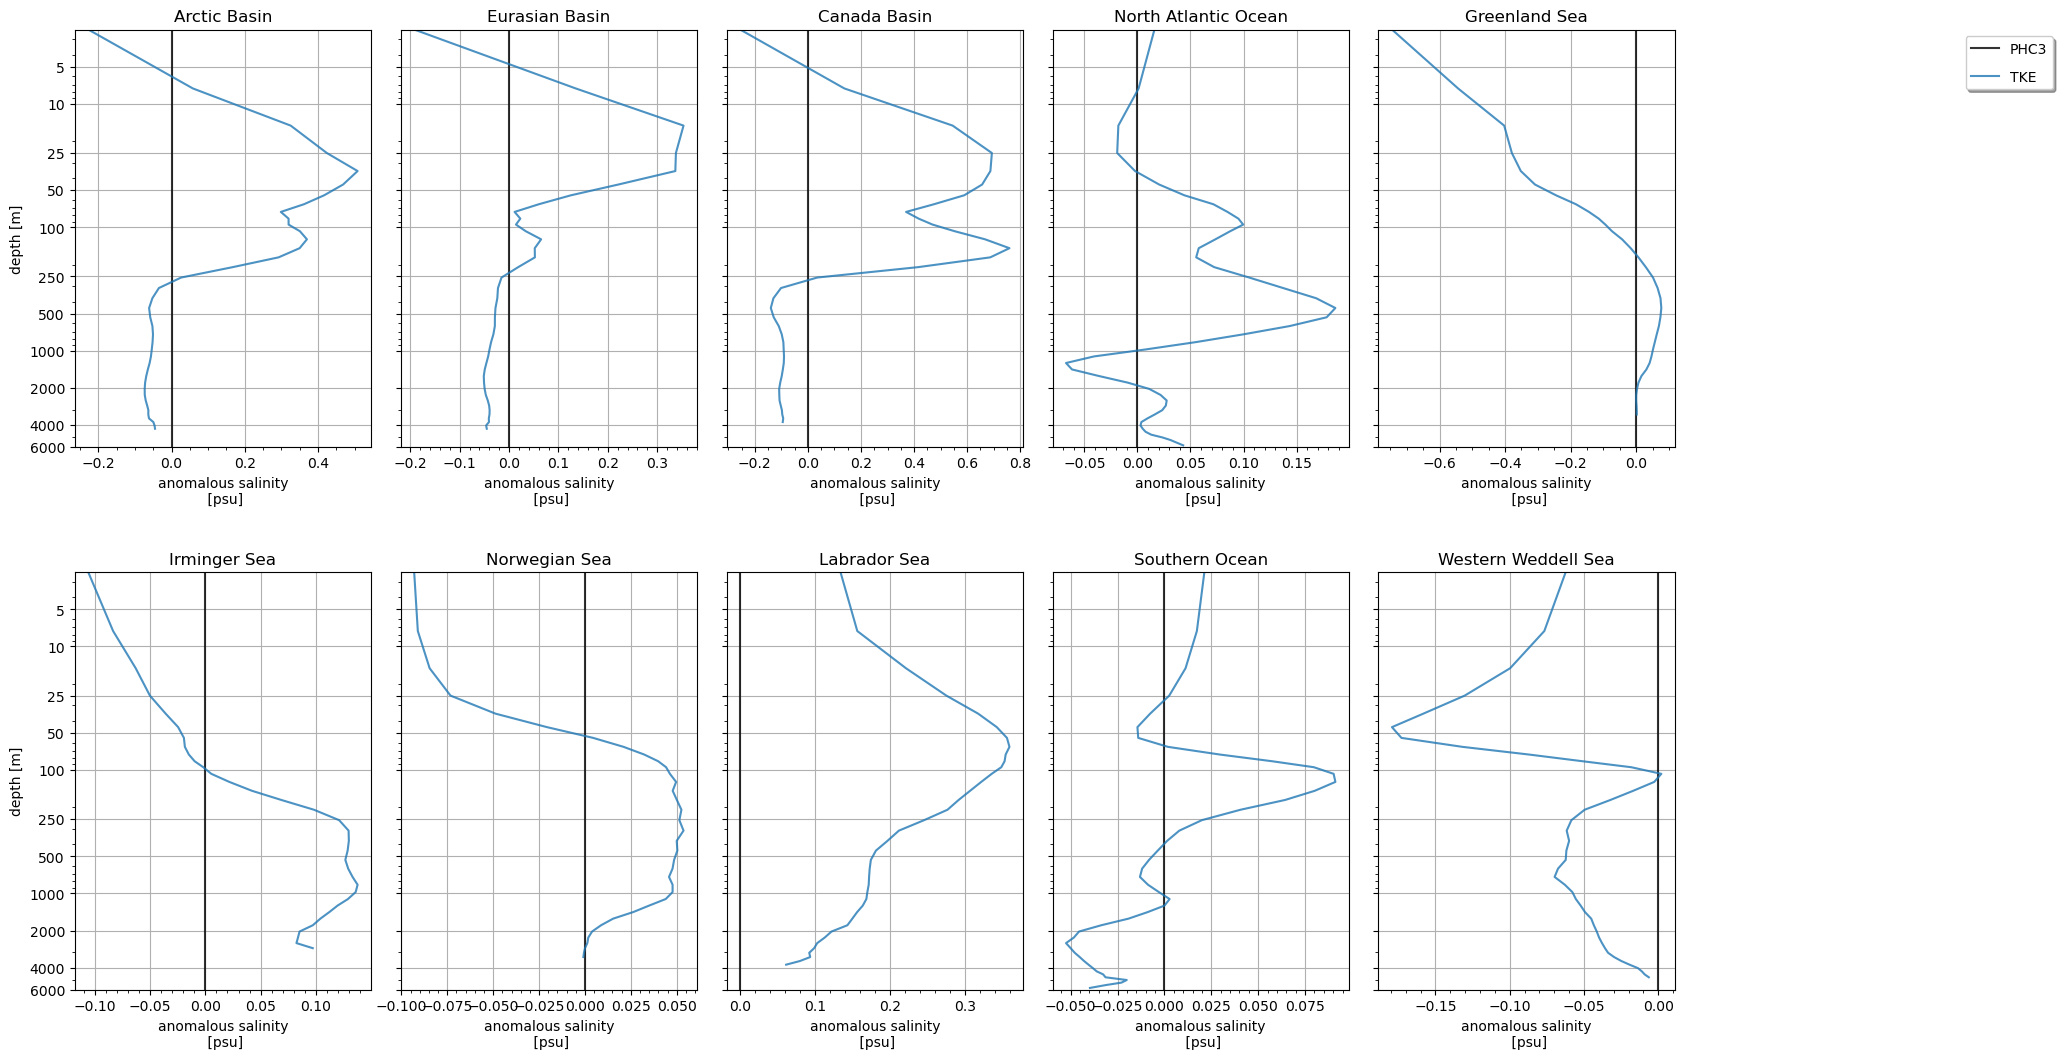

In [5]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = data[sname].attrs['str_lsave']
if spath is not None: spath  = '{}/{}_{}_{}.png'.format(spath, which_mode, sname, slabel) 
nrow   = 2 
if save_fname is not None: spath = save_fname
fig, ax = tpv.plot_index_z(list_index,
                       list_labels,
                       box, figsize=[20,12], n_rc=[nrow,np.ceil(len(box)/nrow).astype(int)], # n_rc=[3,4],
                       linecolor_list=list_lcolor,
                       linestyle_list=list_lstyle,
                       linewidth = list_lwidth,
                       do_save=spath,
                      )  